In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import json
from PIL import Image
from collections import Counter
import pickle
import random
import shutil
random.seed(42)

In [2]:
base_path = '..'
generate_all_datset_annots = True
pick_validation_from_file = True
num_folds = 5
base_data_dir = 'dataset1_files' if not generate_all_datset_annots else 'all_dataset_files'
input_imgs_path = f'{base_path}/dataset1_files/all_dataset1_imgs' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_imgs'
input_masks_path = f'{base_path}/dataset1_files/all_dataset1_masks' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_masks'
input_annots_path = f'{base_path}/dataset1_files/all_dataset1_annotations' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_annotations'
modes = ['train', 'validation']
validation_imgs = set()
validation_masks = set()


for i in range(num_folds):
    temp_input_imgs_path = f'{base_path}/dataset1_files/all_dataset1_imgs_margins_temp_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_imgs_margins_temp_{i}'
    temp_input_masks_path = f'{base_path}/dataset1_files/all_dataset1_masks_margins_temp_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_masks_margins_temp_{i}'
    if os.path.exists(temp_input_imgs_path):
      shutil.rmtree(temp_input_imgs_path)
    if os.path.exists(temp_input_masks_path):
      shutil.rmtree(temp_input_masks_path)
    os.mkdir(temp_input_imgs_path)
    os.mkdir(temp_input_masks_path)
    for mode in modes:
      output_imgs_path = f'{base_path}/dataset1_files/all_dataset1_{mode}_imgs_margins_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_{mode}_imgs_margins_{i}'
      output_annots_path = f'{base_path}/dataset1_files/all_dataset1_{mode}_annotations_margins_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_{mode}_annotations_margins_{i}'
      if os.path.exists(output_imgs_path):
        shutil.rmtree(output_imgs_path)
      if os.path.exists(output_annots_path):
        shutil.rmtree(output_annots_path)
      os.mkdir(output_imgs_path)
      os.mkdir(output_annots_path)

In [3]:
def get_count_type(tiles_dict):
  ids_with_info = []
  for tile in tiles_dict:
    cur_dict = {'id': tile['id'], 'blood_vessel': 0, 'glomerulus': 0, 'unsure': 0}
    for annot in tile['annotations']:
      cur_dict[annot['type']] += 1
    ids_with_info.append(cur_dict)
  return ids_with_info
def calculate_area(coordinates):
    num_points = len(coordinates)
    if num_points < 3:
        return 0

    area = 0
    for i in range(num_points - 1):
        x_i, y_i = coordinates[i]
        x_iplus1, y_iplus1 = coordinates[i + 1]
        area += (x_i * y_iplus1) - (x_iplus1 * y_i)

    x_n, y_n = coordinates[-1]
    x_0, y_0 = coordinates[0]
    area += (x_n * y_0) - (x_0 * y_n)

    area = abs(area / 2)
    return area
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(30, 30))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [4]:
with open(f'{base_path}/polygons.jsonl', 'r') as json_file:
    json_list = list(json_file)
    
tiles_dicts = []
for json_str in json_list:
    tiles_dicts.append(json.loads(json_str))

In [5]:
tile_df = pd.read_csv(f'{base_path}/tile_meta.csv')
# Find the same stats as the above cell for annotated images
annotated_ids_with_info = get_count_type(tiles_dicts)
annotated_ids_with_info_df = pd.DataFrame.from_dict(annotated_ids_with_info)
tile_df_annotated = pd.merge(tile_df, annotated_ids_with_info_df, on='id', how='inner')
tile_df_annotated.head()

id  source_wsi  dataset      i      j  blood_vessel  glomerulus  \
0  0006ff2aa7cd           2        2  16896  16420             8           1   
1  00168d1b7522           2        2  14848  14884             1           1   
2  0033bbc76b6b           1        1  10240  43008             3           0   
3  003504460b3a           3        2   8192  11776             7           0   
4  004daf1cbe75           3        2   6144  11264            10           1   

   unsure  
0       0  
1       0  
2       1  
3       0  
4       0

In [6]:
import random
random.seed(42)
tgt_wsis = [1,2,3,4]
wsi_dicts = dict()
wsi_tile_ids = []
tile_id_to_wsi_dict = dict()
for cur_tgt_wsi in tgt_wsis:
    if generate_all_datset_annots:
        pos_dict = {(x[0], x[1]): x[-1] for x in tile_df_annotated.loc[tile_df_annotated['source_wsi']==cur_tgt_wsi, ['i', 'j', 'id']].values}
        wsi_ids = list(tile_df_annotated.loc[tile_df_annotated['source_wsi']==cur_tgt_wsi, 'id'].values)
    else:
        pos_dict = {(x[0], x[1]): x[-1] for x in tile_df_annotated.loc[(tile_df_annotated['dataset']==1) & (tile_df_annotated['source_wsi']==cur_tgt_wsi), ['i', 'j', 'id']].values}
        wsi_ids = list(tile_df_annotated.loc[(tile_df_annotated['dataset']==1) & (tile_df_annotated['source_wsi']==cur_tgt_wsi), 'id'].values)
    random.shuffle(wsi_ids)
    wsi_tile_ids.append(wsi_ids)
    reverse_pos_dict = {v:k for k,v in pos_dict.items()}
    wsi_dicts[cur_tgt_wsi] = (pos_dict, reverse_pos_dict)
    tile_id_to_wsi_dict.update({wsi_id: cur_tgt_wsi for wsi_id in wsi_ids})

In [7]:
dataset_1_tile_ids = sorted(list(tile_df_annotated.loc[tile_df_annotated['dataset']==1, 'id'].values))
all_dataset_tile_ids = sorted(list(tile_df_annotated.loc[:, 'id'].values))

In [8]:
def get_segmentation_coordinates(mask):
    mask = np.uint8(mask)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation_coords = []
    for contour in contours:
        contour = np.squeeze(contour)
        coords = contour.flatten().tolist()
        segmentation_coords.append(coords)
    return segmentation_coords

def create_coco_annots(all_coords, pair_format=True):
  cur_tile_coco_annots = []
  for coords in all_coords:
    if not pair_format:
      coords = [[pt[0], pt[1]] for pt in zip(coords[::2], coords[1::2])]
    segmentations = [[pt for pair in coords for pt in pair]]
    segmentation_area = calculate_area(coords)
    min_x = min(coords, key=lambda x: x[0])[0]
    max_x = max(coords, key=lambda x: x[0])[0]
    min_y = min(coords, key=lambda x: x[1])[1]
    max_y = max(coords, key=lambda x: x[1])[1]
    segmentation_bbox = [min_x, min_y, max_x-min_x, max_y-min_y]
    category_id = 0
    cur_tile_coco_annots.append({
      'segmentation': segmentations,
      'area': segmentation_area,
      'bbox': segmentation_bbox,
      'category_id': category_id
    })
  return cur_tile_coco_annots

In [9]:
def load_img(img_dir, img_id, is_grayscale=False):
    if not is_grayscale:
        img = cv2.imread(f"{img_dir}/{img_id}.png")
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.imread(f"{img_dir}/{img_id}.png", cv2.IMREAD_GRAYSCALE)
    return img

def create_hor_margins(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, is_top, is_train, margin_size=32, is_mask=False):
    is_grayscale = True if is_mask else False
    cur_validation_imgs = validation_imgs if not is_mask else validation_masks
    
    left_img_i = img_i - 512
    left_img_j = img_j - 512 if is_top else img_j + 512
    left_piece = np.zeros((margin_size, margin_size), dtype='uint8') if is_grayscale else np.zeros((margin_size, margin_size, 3), dtype='uint8')
    if (left_img_i, left_img_j) in dataset_pos_dict:
        cur_img_id = dataset_pos_dict[(left_img_i, left_img_j)]
        img_load_dir = temp_input_imgs_dir if (is_train and cur_img_id in cur_validation_imgs) else input_imgs_dir
        cur_img = load_img(img_load_dir, cur_img_id, is_grayscale=is_grayscale)
        left_piece = cur_img[-margin_size:, -margin_size:] if is_top else cur_img[:margin_size, -margin_size:]
        if not is_train:
          validation_load_dir = temp_input_imgs_dir if cur_img_id in cur_validation_imgs else input_imgs_dir
          validation_img = load_img(validation_load_dir, cur_img_id, is_grayscale=is_grayscale)
#           print('======')
#           print(validation_load_dir)
#           print(cur_img_id)
#           print('======')
          if is_top:
            validation_img[-margin_size:, -margin_size:] = 0
          else:
            validation_img[:margin_size, -margin_size:] = 0
          cv2.imwrite(f'{temp_input_imgs_dir}/{cur_img_id}.png', validation_img)
          cur_validation_imgs.add(cur_img_id)
    
    middle_img_i = img_i
    middle_img_j = img_j - 512 if is_top else img_j + 512
    middle_piece = np.zeros((margin_size, 512), dtype='uint8') if is_grayscale else np.zeros((margin_size, 512, 3), dtype='uint8')
    if (middle_img_i, middle_img_j) in dataset_pos_dict:
        cur_img_id = dataset_pos_dict[(middle_img_i, middle_img_j)]
        img_load_dir = temp_input_imgs_dir if (is_train and cur_img_id in cur_validation_imgs) else input_imgs_dir
        cur_img = load_img(img_load_dir, cur_img_id, is_grayscale=is_grayscale)
        middle_piece = cur_img[-margin_size:] if is_top else cur_img[:margin_size]
        if not is_train:
          validation_load_dir = temp_input_imgs_dir if cur_img_id in cur_validation_imgs else input_imgs_dir
          validation_img = load_img(validation_load_dir, cur_img_id, is_grayscale=is_grayscale)
#           print('======')
#           print(validation_load_dir)
#           print(cur_img_id)
#           print('======')
          if is_top:
            validation_img[-margin_size:] = 0
          else:
            validation_img[:margin_size] = 0
          cv2.imwrite(f'{temp_input_imgs_dir}/{cur_img_id}.png', validation_img)
          cur_validation_imgs.add(cur_img_id)
    
    right_img_i = img_i + 512
    right_img_j = img_j - 512 if is_top else img_j + 512
    right_piece = np.zeros((margin_size, margin_size), dtype='uint8') if is_grayscale else np.zeros((margin_size, margin_size, 3), dtype='uint8')
    if (right_img_i, right_img_j) in dataset_pos_dict:
        cur_img_id = dataset_pos_dict[(right_img_i, right_img_j)]
        img_load_dir = temp_input_imgs_dir if (is_train and cur_img_id in cur_validation_imgs) else input_imgs_dir
        cur_img = load_img(img_load_dir, cur_img_id, is_grayscale=is_grayscale)
        right_piece = cur_img[-margin_size:, :margin_size] if is_top else cur_img[:margin_size, :margin_size]
        if not is_train:
          validation_load_dir = temp_input_imgs_dir if cur_img_id in cur_validation_imgs else input_imgs_dir
          validation_img = load_img(validation_load_dir, cur_img_id, is_grayscale=is_grayscale)
#           print('======')
#           print(validation_load_dir)
#           print(cur_img_id)
#           print('======')
          if is_top:
            validation_img[-margin_size:, :margin_size] = 0
          else:
            validation_img[:margin_size, :margin_size] = 0
          cv2.imwrite(f'{temp_input_imgs_dir}/{cur_img_id}.png', validation_img)
          cur_validation_imgs.add(cur_img_id)
    
    return cv2.hconcat([left_piece, middle_piece, right_piece])

def create_vert_margins(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, is_left, is_train, margin_size=32, is_mask=False):
    is_grayscale = True if is_mask else False
    cur_validation_imgs = validation_imgs if not is_mask else validation_masks
    
    middle_img_i = img_i - 512 if is_left else img_i + 512
    middle_img_j = img_j
    middle_piece = np.zeros((512, margin_size), dtype='uint8') if is_grayscale else np.zeros((512, margin_size, 3), dtype='uint8')
    if (middle_img_i, middle_img_j) in dataset_pos_dict:
        cur_img_id = dataset_pos_dict[(middle_img_i, middle_img_j)]
        img_load_dir = temp_input_imgs_dir if (is_train and cur_img_id in cur_validation_imgs) else input_imgs_dir
        cur_img = load_img(img_load_dir, cur_img_id, is_grayscale=is_grayscale)
        middle_piece = cur_img[:, -margin_size:] if is_left else cur_img[:, :margin_size]
        if not is_train:
          validation_load_dir = temp_input_imgs_dir if cur_img_id in cur_validation_imgs else input_imgs_dir
          validation_img = load_img(validation_load_dir, cur_img_id, is_grayscale=is_grayscale)
          if is_left:
            validation_img[:, -margin_size:] = 0
          else:
            validation_img[:, :margin_size] = 0
          cv2.imwrite(f'{temp_input_imgs_dir}/{cur_img_id}.png', validation_img)
          cur_validation_imgs.add(cur_img_id)
    return middle_piece

def get_layered_img(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, is_train, margin_size=32, is_mask=False):
    is_grayscale = True if is_mask else False
    cur_validation_imgs = validation_imgs if not is_mask else validation_masks
    
    img_load_dir = temp_input_imgs_dir if (is_train and img_id in cur_validation_imgs) else input_imgs_dir
    img = load_img(img_load_dir, img_id, is_grayscale=is_grayscale)
    
    top_margin = create_hor_margins(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, True, is_train, margin_size=margin_size, is_mask=is_mask)
    bottom_margin = create_hor_margins(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, False, is_train, margin_size=margin_size, is_mask=is_mask)
    left_margin = create_vert_margins(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, True, is_train, margin_size=margin_size, is_mask=is_mask)
    right_margin = create_vert_margins(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, False, is_train, margin_size=margin_size, is_mask=is_mask)
#     print(left_margin.shape, img.shape, right_margin.shape, left_margin.dtype, img.dtype, right_margin.dtype)
    middle_piece = cv2.hconcat([left_margin, img, right_margin])
    
    if not is_train:
      validation_img = load_img(input_imgs_dir, img_id, is_grayscale=is_grayscale)
      validation_img = np.zeros_like(validation_img, dtype='uint8')
      cv2.imwrite(f'{temp_input_imgs_dir}/{img_id}.png', validation_img)
      cur_validation_imgs.add(img_id)
    
    return cv2.vconcat([top_margin, middle_piece, bottom_margin])

def save_margin_imgs(input_imgs_dir, temp_input_imgs_dir, output_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, is_train, margin_size=32, is_mask=False):
  img = get_layered_img(input_imgs_dir, temp_input_imgs_dir, img_id, img_i, img_j, dataset_pos_dict, is_train, margin_size=margin_size, is_mask=is_mask)
  cv2.imwrite(f'{output_imgs_dir}/{img_id}.png', img)

def save_margin_annots(input_masks_dir, temp_input_masks_dir, output_annots_dir, img_id, img_i, img_j, dataset_pos_dict, is_train, margin_size=32, is_mask=True):
  mask = get_layered_img(input_masks_dir, temp_input_masks_dir, img_id, img_i, img_j, dataset_pos_dict, is_train, margin_size=margin_size, is_mask=is_mask)
  mask_coords = get_segmentation_coordinates(mask)
  mask_annots = create_coco_annots(mask_coords, pair_format=False)
  with open(f'{output_annots_dir}/{img_id}.pkl', 'wb') as f:
    pickle.dump(mask_annots, f, protocol=pickle.HIGHEST_PROTOCOL)

In [10]:
import math
fold_size = int(math.ceil(len(all_dataset_tile_ids) / num_folds))
fold_size

327

In [11]:
fold_size = int(math.ceil(len(dataset_1_tile_ids) / num_folds)) if not generate_all_datset_annots else int(math.ceil(len(all_dataset_tile_ids) / num_folds))
print(f'Fold size is {fold_size}')
for i in range(1):
  temp_input_imgs_path = f'{base_path}/dataset1_files/all_dataset1_imgs_margins_temp_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_imgs_margins_temp_{i}'
  temp_input_masks_path = f'{base_path}/dataset1_files/all_dataset1_masks_margins_temp_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_masks_margins_temp_{i}'
  
  output_imgs_train_path = f'{base_path}/dataset1_files/all_dataset1_train_imgs_margins_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_train_imgs_margins_{i}'
  output_annots_train_path = f'{base_path}/dataset1_files/all_dataset1_train_annotations_margins_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_train_annotations_margins_{i}'
  output_imgs_validation_path = f'{base_path}/dataset1_files/all_dataset1_validation_imgs_margins_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_validation_imgs_margins_{i}'
  output_annots_validation_path = f'{base_path}/dataset1_files/all_dataset1_validation_annotations_margins_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_validation_annotations_margins_{i}'
  
  if pick_validation_from_file:
    with open(f'{base_path}/{base_data_dir}/validation_img_ids_fold_{i}.pkl', 'rb') as f:
        cur_validation_slice = pickle.load(f)
    with open(f'{base_path}/{base_data_dir}/train_img_ids_fold_{i}.pkl', 'rb') as f:
        cur_training_slice = pickle.load(f)
    print(len(cur_validation_slice), len(cur_training_slice))
    print(cur_validation_slice)
  else:
    cur_validation_slice = []
    num_wsis = float(len(wsi_tile_ids))
    for wsi_tile_id in wsi_tile_ids:
      cur_validation_slice += wsi_tile_id[int(i*(fold_size/num_wsis)):min(int((i+1)*(fold_size/num_wsis)), len(wsi_tile_id))]
    cur_training_slice = list(set(dataset_1_tile_ids) - set(cur_validation_slice)) if not generate_all_datset_annots else list(set(all_dataset_tile_ids) - set(cur_validation_slice))
  
  for idx, img_id in enumerate(cur_validation_slice):
#     print(f'Processing id {img_id}')
    source_wsi = tile_id_to_wsi_dict[img_id]
    dataset_pos_dict, dataset_reverse_pos_dict = wsi_dicts[source_wsi]
    img_i, img_j = dataset_reverse_pos_dict[img_id]
    save_margin_imgs(input_imgs_path, temp_input_imgs_path, output_imgs_validation_path, img_id, img_i, img_j, dataset_pos_dict, False, margin_size=64, is_mask=False)
  #   print('Finished saving images')
    save_margin_annots(input_masks_path, temp_input_masks_path, output_annots_validation_path, img_id, img_i, img_j, dataset_pos_dict, False, margin_size=64, is_mask=True)
  #   print('Finished saving annots')
  #   print('================')
  for idx, img_id in enumerate(cur_training_slice):
    source_wsi = tile_id_to_wsi_dict[img_id]
    dataset_pos_dict, dataset_reverse_pos_dict = wsi_dicts[source_wsi]
    img_i, img_j = dataset_reverse_pos_dict[img_id]
    save_margin_imgs(input_imgs_path, temp_input_imgs_path, output_imgs_train_path, img_id, img_i, img_j, dataset_pos_dict, True, margin_size=64, is_mask=False)
    save_margin_annots(input_masks_path, temp_input_masks_path, output_annots_train_path, img_id, img_i, img_j, dataset_pos_dict, True, margin_size=64, is_mask=True)

Fold size is 327
324 1309
['cfb0bd617652', '678c51bde237', '2519a0f1b867', '523a3912a7ee', '9a70c2d9e4f4', 'ca081412bad8', 'd9547a630fab', '5384b927f5b3', '2d2093e38e39', '3e248be7dd4c', '39b8aafd630b', '578c8b32057e', '4c058755d597', '23c30a541c7a', '9f999c74b67e', '0e8aed930dc6', '03d335057db3', '328a651a4ca7', '55b07829e888', '4cf2563142f4', '6d1315ab9ef7', '7483bb77d145', 'e506a133c873', '18be061202ea', 'f1af97caff9d', 'db8adbc51c82', '13aa34ced90d', '8f6f3e18eda5', '033a656390b2', '5ed62676da45', '76e5b8a1caa1', '415a900f7a89', '9ed941a933d0', 'ac68833641fe', '1c0295c1d01d', '4a1b99c7ab16', 'f6b0c55c34c7', '15ed954c0cdf', '0a993633aa5e', 'd6529e6e8602', '242db333c452', '8e90e6189c6b', '783e8f735476', '4b197545ea0e', '45d6f53ececf', '5a89c7f7ad05', '9b95807e6b23', '30ad648e36a2', 'cb96f7b681f8', '4e8b6849684d', '303b72a38e29', '41225437e33e', 'ac8f685801d0', 'abbacf024cb5', '95c077870f91', 'dcea4e9d6726', '7392e21e0fe2', 'e1647f94f1f9', '1a54cda8f32d', '1f0d3cd4b621', 'f40804ea84e6

In [25]:
'f1af97caff9d' in cur_validation_slice

True

{'TL': '7ae0eb4bda2c', 'U': 'be9250fc8ec5', 'TR': '5a89c7f7ad05', 'L': 'e283ea6e3f7b', 'C': 'f1af97caff9d', 'R': '39b8aafd630b', 'BL': '4eb2a2b392f6', 'B': '209426451a36', 'BR': 'f6afc2903670'}
[[177 198 202 206 211 188 176 201 214 219]
 [202 208 193 183 188 177 170 187 208 217]
 [201 198 176 160 170 177 176 183 201 213]
 [194 193 177 163 171 187 190 188 197 210]
 [208 205 194 178 172 186 197 194 198 209]
 [211 199 191 176 162 177 202 208 205 212]
 [207 185 181 178 164 180 212 222 214 215]
 [218 189 189 195 182 192 219 225 221 218]
 [214 209 197 186 187 200 209 212 219 214]
 [192 199 200 191 185 191 201 209 220 217]] [[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]] [[187 208 212 216 219 196 184 207 222 225]
 [212 218 203 193 196 185 178 193 216 223]
 [211 208 186 170 178 185 184 189 209 219]
 [204 203 187 1

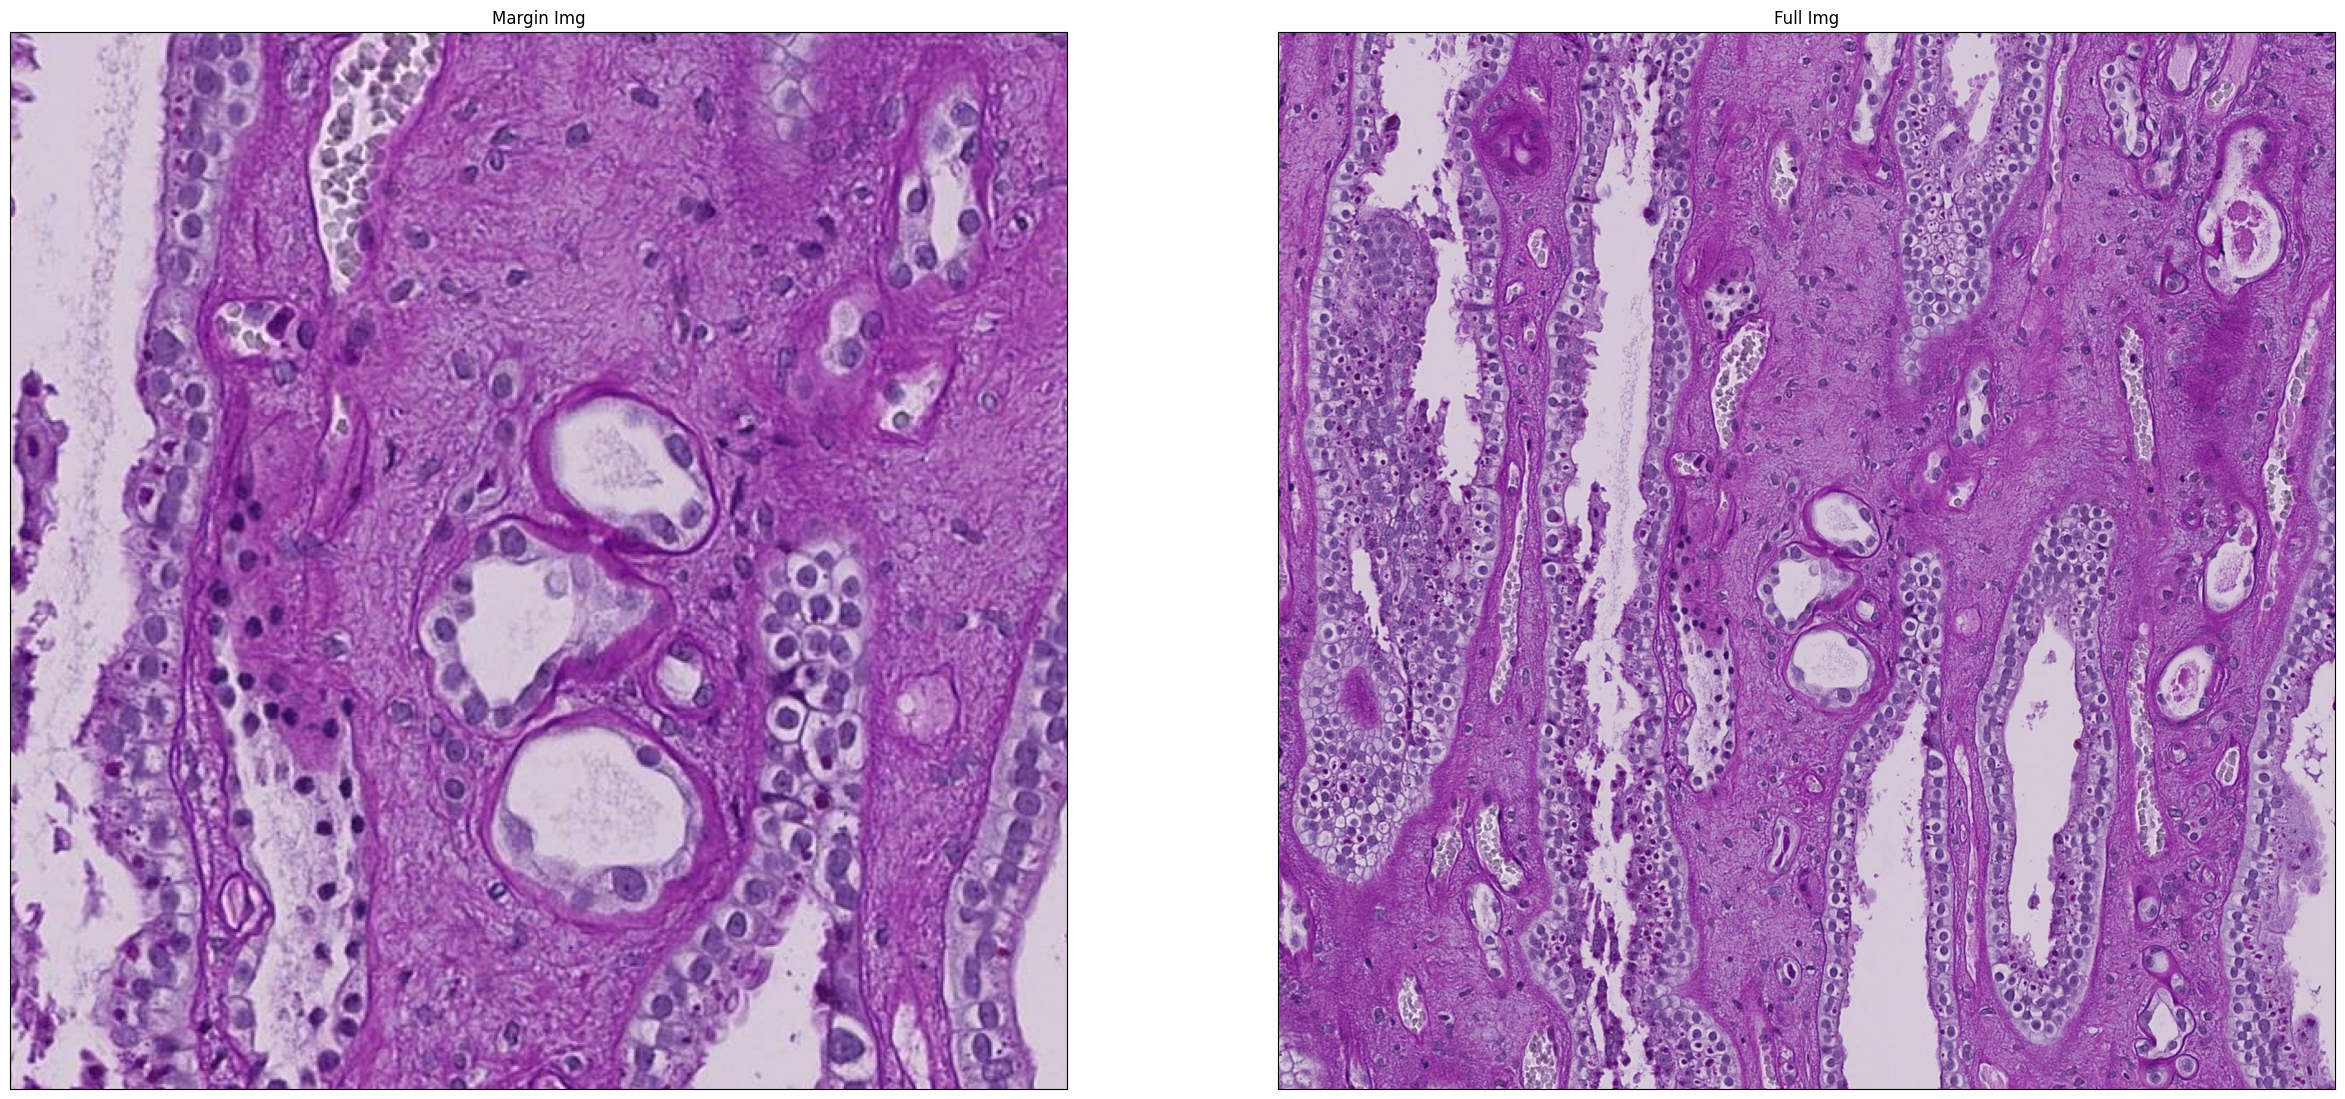

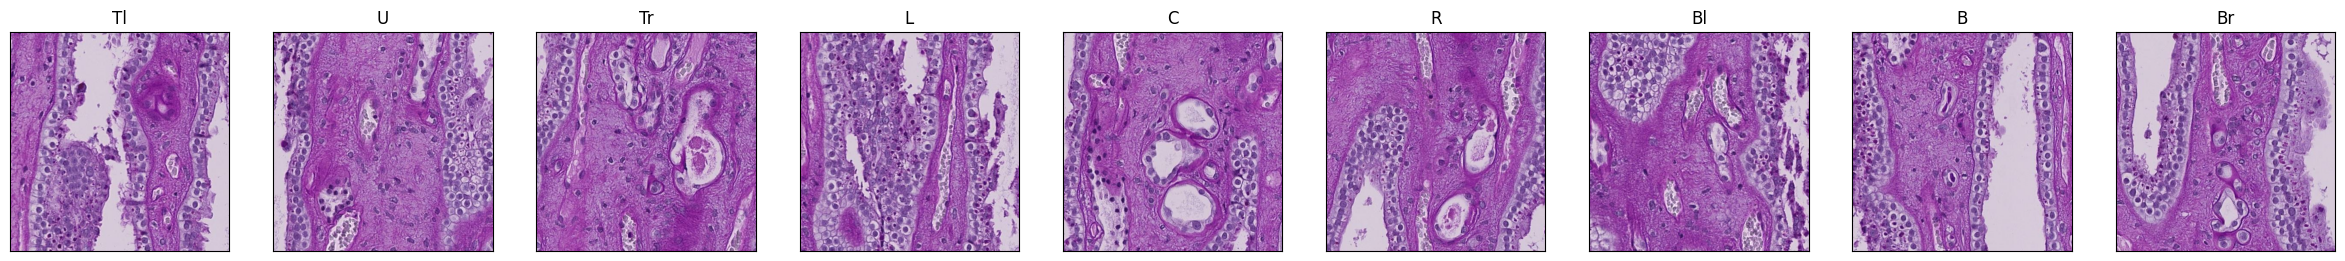

In [26]:
img_id = 'f1af97caff9d'
mode='validation'
i=0
temp_input_imgs_path = f'{base_path}/dataset1_files/all_dataset1_imgs_margins_temp_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_imgs_margins_temp_{i}'


source_wsi = tile_id_to_wsi_dict[img_id]
dataset_pos_dict, dataset_reverse_pos_dict = wsi_dicts[source_wsi]
img_i, img_j = dataset_reverse_pos_dict[img_id]
adjacency_pos_dict = {'TL': (-1,-1), 'U': (0,-1), 'TR': (1,-1), 'L': (-1,0), 'C': (0,0), 'R': (1,0), 'BL': (-1,1), 'B': (0,1), 'BR': (1,1)}
keys = ['TL', 'U', 'TR', 'L', 'C', 'R', 'BL', 'B', 'BR']
adjacency_dict = dict()
vis_dict = dict()
imgs = []
img_rows = []
for idx, k in enumerate(keys):
  i_scale, j_scale = adjacency_pos_dict[k]
  cur_i = img_i + i_scale * 512
  cur_j = img_j + j_scale * 512
  cur_img_id = 'NA'
  cur_img = np.zeros((512,512, 3), dtype='uint8')
  if (cur_i, cur_j) in dataset_pos_dict:
    cur_img_id = dataset_pos_dict[(cur_i, cur_j)]
    cur_img = load_img(input_imgs_path, cur_img_id)
  vis_dict[k] = cur_img
  imgs.append(cur_img)
  adjacency_dict[k] = cur_img_id
  if len(imgs) % 3 == 0:
#     print(imgs[0].shape, imgs[1].shape, imgs[2].shape)
    img_rows.append(cv2.hconcat(imgs))
    imgs = []
print(adjacency_dict)
output_imgs_path = f'{base_path}/dataset1_files/all_dataset1_{mode}_imgs_margins_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_{mode}_imgs_margins_{i}'
margin_img = load_img(output_imgs_path, img_id)
# plt.imshow(cv2.vconcat(img_rows))
# plt.show()
# plt.imshow(cv2.vconcat(img_rows))
# plt.show()
# test_img = load_img(input_imgs_path, img_id)
test_img = load_img(input_imgs_path, img_id)
# test_img_temp = load_img(temp_input_imgs_path, img_id)
test_img_temp = cv2.imread(f'{temp_input_imgs_path}/{img_id}.png')
test_img_temp_2 = np.array(Image.open(f'{input_imgs_path}/{img_id}.png'))
# test_img_temp_2 = cv2.imread(f'{temp_input_imgs_path}/{img_id}.png')
print(test_img[:10, :10, 0], test_img_temp[:10, :10, 0], test_img_temp_2[:10,:10,0])
visualize(**{'margin_img': margin_img, 'full_img':cv2.vconcat(img_rows)})
visualize(**vis_dict)

In [ ]:
img_id = 'fcbe5ce12d5f'
mode='train'
i=0
temp_input_imgs_path = f'{base_path}/dataset1_files/all_dataset1_imgs_margins_temp_{i}' if not generate_all_datset_annots else f'{base_path}/all_dataset_files/all_dataset_imgs_margins_temp_{i}'